In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
genecode_fn = '/gladstone/engelhardt/lab/hvu/data/genecode/hg38/gencode.v46.basic.annotation_clean.csv.gz'
df = pd.read_csv(genecode_fn, header=0, index_col=None, sep='\t')
# only get protein coding genes
df = df[df['gene_type'] == 'protein_coding']


/tmp/ipykernel_3167018/855765388.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(genecode_fn, header=0, index_col=None, sep='\t')


/tmp/ipykernel_3167018/283029729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript_df['length'] = transcript_df['end'] - transcript_df['start'] + 1


28345.0
count    6.475800e+04
mean     6.837918e+04
std      1.260067e+05
min      2.700000e+01
25%      1.051850e+04
50%      2.834500e+04
75%      7.271200e+04
max      2.471657e+06
Name: length, dtype: float64


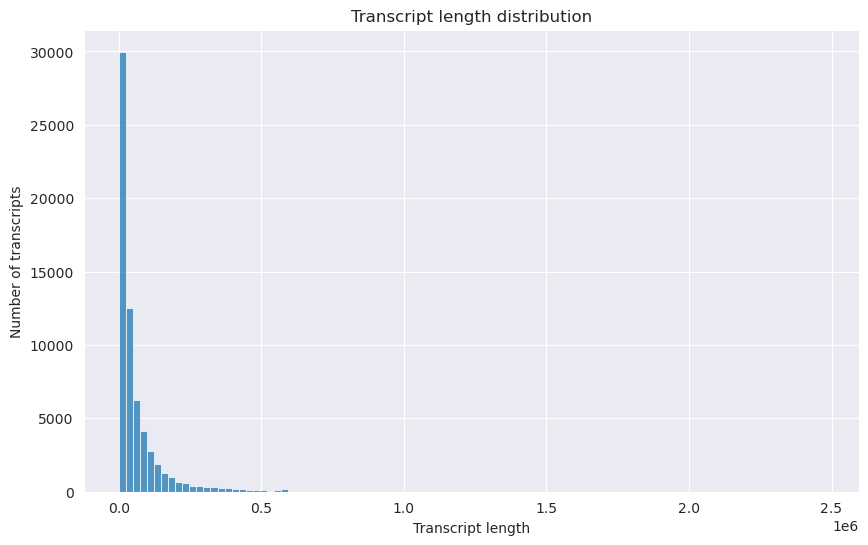

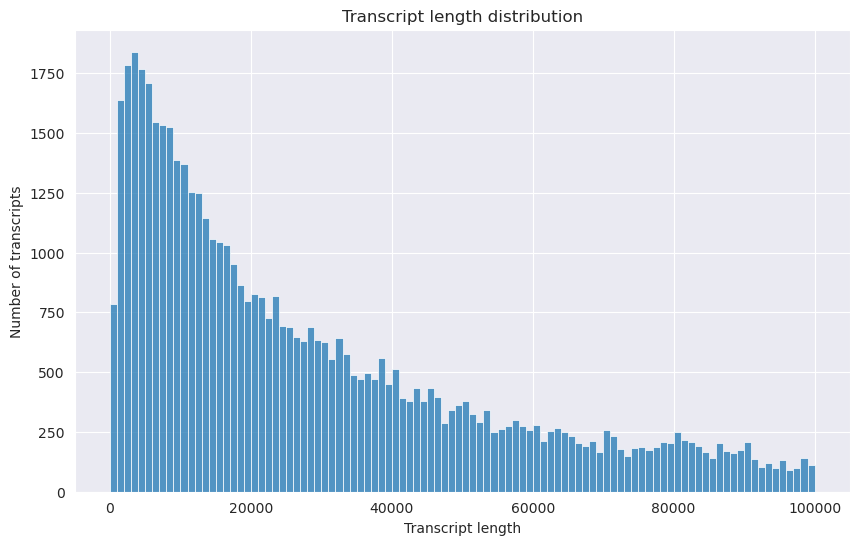

In [3]:
# what is the typical length of a transcript
transcript_df = df[df['feature']=='transcript']
transcript_df['length'] = transcript_df['end'] - transcript_df['start'] + 1
plt.figure(figsize=(10, 6))
sns.histplot(transcript_df['length'], bins=100, kde=False)
plt.xlabel('Transcript length')
plt.ylabel('Number of transcripts')
plt.title('Transcript length distribution')
transcript_df['length'].describe()
# only get the transcripts with length less than 100,000bp
majority_transcript_df  = transcript_df[transcript_df['length']<=100000]
plt.figure(figsize=(10, 6))
sns.histplot(majority_transcript_df['length'], bins=100, kde=False)
plt.xlabel('Transcript length')
plt.ylabel('Number of transcripts')
plt.title('Transcript length distribution')
# print median transcript length
print(transcript_df['length'].median())
print(transcript_df['length'].describe())

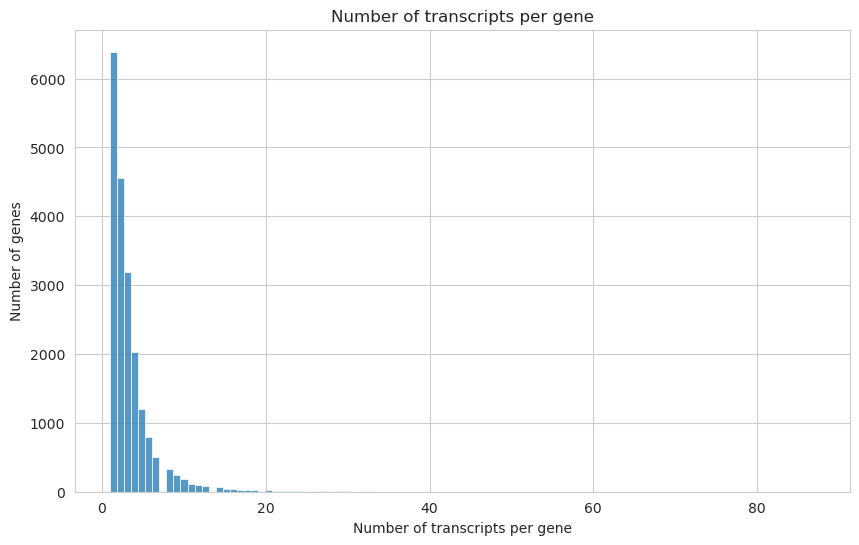

transcript_count
1     6391
2     4561
3     3189
4     2027
5     1203
6      799
7      501
8      329
9      240
10     178
11     117
12      97
13      90
14      68
15      36
16      33
17      25
19      23
20      21
18      21
23      16
21      15
22      12
24      10
26       9
25       6
27       4
32       4
30       4
29       4
44       3
36       3
33       3
31       3
37       3
39       3
34       2
35       2
50       1
87       1
53       1
47       1
62       1
42       1
72       1
38       1
48       1
41       1
Name: count, dtype: int64


In [6]:
# first, count the number of transcripts in each gene (I assume each transcript corresponds to a canical isoform or alternative isoform)
trans_count_df = df[df['feature']=='transcript'].groupby('gene_id').size().reset_index(name='transcript_count')
# draw the histogram of number of transcripts per gene
plt.figure(figsize=(10, 6))
sns.histplot(trans_count_df['transcript_count'], bins=100, kde=False)
plt.xlabel('Number of transcripts per gene')
plt.ylabel('Number of genes')
plt.title('Number of transcripts per gene')
plt.show()
# print the count of the transcript_count
print(trans_count_df['transcript_count'].value_counts())

/tmp/ipykernel_1311856/2501675310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exon_df['length'] = exon_df['end'] - exon_df['start'] + 1


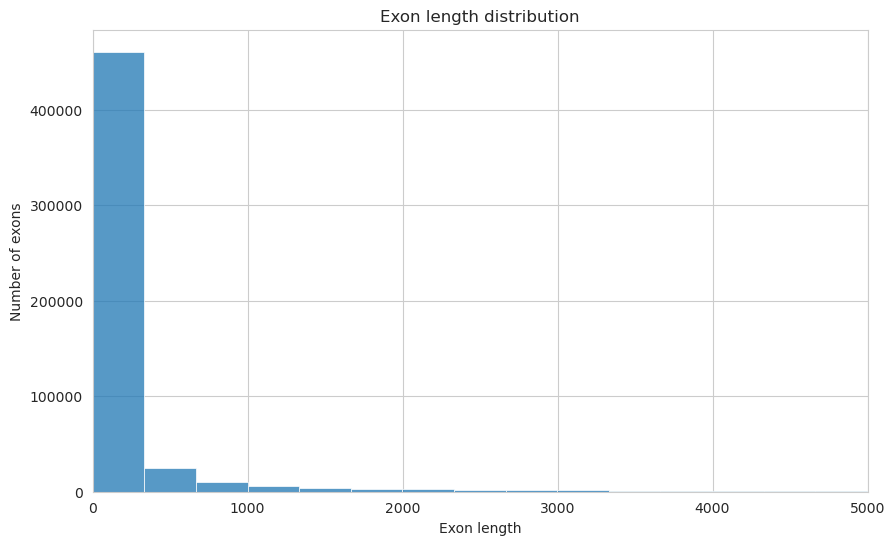

count    523095.000000
mean        292.983821
std         737.821144
min           2.000000
25%          92.000000
50%         131.000000
75%         190.000000
max       33290.000000
Name: length, dtype: float64


In [2]:
# draw histograms of the exon lengths
exon_df = df[(df['feature']=='exon') & (df['tag']=='CCDS')]  # exons that are part of Consensus Coding Sequence (CCDS) project 
exon_df['length'] = exon_df['end'] - exon_df['start'] + 1
plt.figure(figsize=(10, 6))
sns.histplot(exon_df['length'], bins=100, kde=False)
plt.xlabel('Exon length')
plt.ylabel('Number of exons')
plt.title('Exon length distribution')
plt.xlim(0, 5000)
plt.show()
print(exon_df['length'].describe())

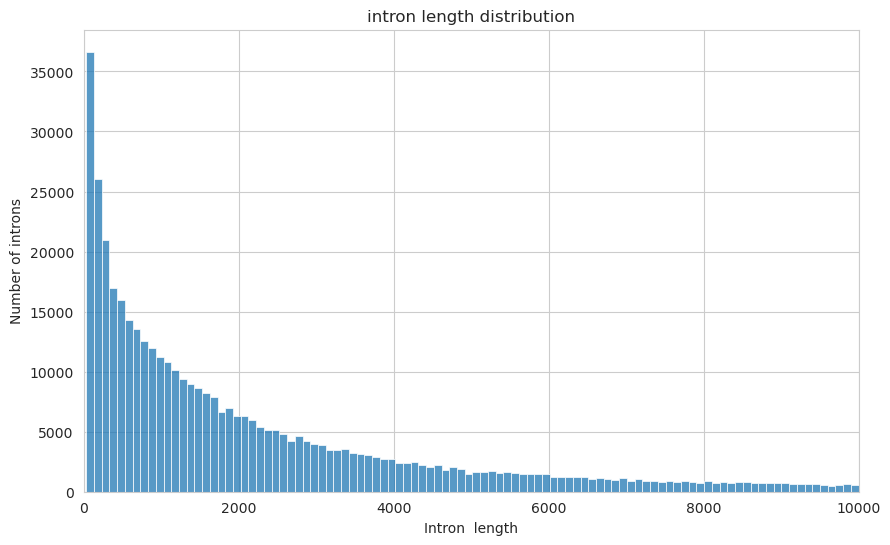

count    4.762900e+05
mean     6.440259e+03
std      2.065172e+04
min      3.400000e+01
25%      5.500000e+02
50%      1.651000e+03
75%      4.499000e+03
max      1.160411e+06
Name: length, dtype: float64


In [3]:
# now, let's draw the histogram of the intron lengths
# but first, we have to figure the length of the introns
# Function to calculate intron lengths within each transcript
def calculate_introns(gtf_df):
    introns = []
    transcripts = gtf_df[gtf_df["feature"] == "exon"].groupby("transcript_id")
    for transcript_id, exons in transcripts:
        exons = exons.sort_values(by="start")
        for i in range(1, len(exons)):
            intron_start = exons.iloc[i-1]["end"] + 1
            intron_end = exons.iloc[i]["start"] - 1
            gene_id = exons.iloc[i]["gene_id"]
            if intron_end > intron_start:
                introns.append({
                    'gene_id': gene_id,
                    "transcript_id": transcript_id,
                    "start": intron_start,
                    "end": intron_end,
                    "length": intron_end - intron_start + 1
                })
    
    return pd.DataFrame(introns)


intron_df = calculate_introns(exon_df)
# we will only consider introns that are of the first transcript in a gene. I am making the assumption that the first transcript is the canonical transcript. Filter based on transcript_id and gene_id

# but for now let just draw the histogram of the intron lengths
plt.figure(figsize=(10, 6))

intron_df.rename(columns={'intron_length': 'length'}, inplace=True)
sns.histplot(intron_df[intron_df['length']<=10000]['length'], bins=100, kde=True)
plt.xlabel('Intron  length')
plt.ylabel('Number of introns')
plt.title('intron length distribution')
plt.xlim(0, 10000)
plt.show()
print(intron_df['length'].describe())

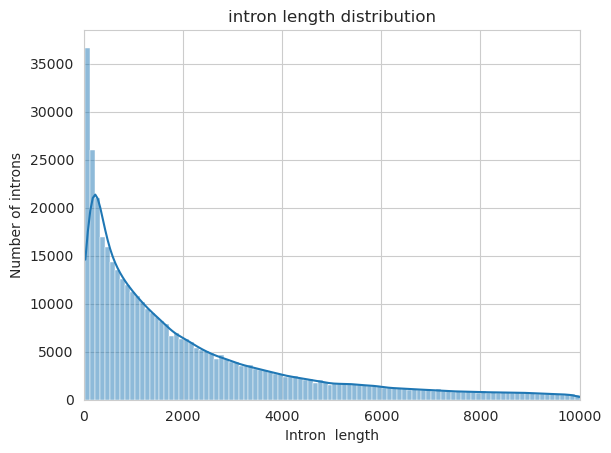

count    4.762900e+05
mean     6.440259e+03
std      2.065172e+04
min      3.400000e+01
25%      5.500000e+02
50%      1.651000e+03
75%      4.499000e+03
max      1.160411e+06
Name: length, dtype: float64


In [4]:
sns.histplot(intron_df[intron_df['length']<=10000]['length'], bins=100, kde=True)
plt.xlabel('Intron  length')
plt.ylabel('Number of introns')
plt.title('intron length distribution')
plt.xlim(0, 10000)
plt.show()
print(intron_df['length'].describe())